In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image
import os
import shutil
import sklearn.model_selection
import matplotlib.pyplot as plt

In [3]:
def convert_image_to_array(img_path, img_width, img_height):
    img = PIL.Image.open(img_path)
    img = img.resize((img_width, img_height))
    return np.array(img.convert('RGB')).reshape((img_width, img_height, 3)).astype('float32')

In [4]:
def convert_dir_to_arrays(dir_path, img_width, img_height):
    files = os.listdir(dir_path)
    arrays = []
    for file in files:
        if file.endswith('.jpg'):
            arrays.append(convert_image_to_array(dir_path+'/' + file, img_width, img_height))
    return np.array(arrays)

In [5]:
def save_data_as_csv(data, path, header):
    if os.path.exists(path):
        data.to_csv(path, mode='a', header=None, index=None)
    else:
        data.to_csv(path, mode='a', header=header, index=None)

In [6]:
class Model:
    def __init__(self):
        self.img_width, self.img_height = 100, 120

        self.data = convert_dir_to_arrays('data/female-face/allpicture', self.img_width, self.img_height)
        self.target = np.array(pd.read_excel('data/female-face/grades.xlsx')['label']) / 5

        self.x_train, self.x_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(self.data, self.target, test_size=0.3)

        self.model = tf.keras.Sequential([
                tf.keras.applications.ResNet50(include_top=False, pooling='avg'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(1, activation='sigmoid')])

        self.base_path = 'face_marking_model'
        self.checkpoint_save_path = 'checkpoint/mnist.ckpt'

        self.cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.base_path + '/' + self.checkpoint_save_path,
                                                              save_weights_only=True,
                                                              save_best_only=True)
        
    def fit(self, epochs, new_model=False):
        if new_model:
            print('[ WARN ] >>> All record of model will be removed!')
            if os.path.exists(self.base_path):
                shutil.rmtree(self.base_path)

        else:
            if os.path.exists(self.base_path + '/' + self.checkpoint_save_path + '.index'):
                print('[ INFO ] >>> Model is exist! Loading the model!')
                self.model.load_weights(self.base_path + '/' + self.checkpoint_save_path)
            else:
                print('[ INFO ] >>> Model is not exist! Creating the model!')

        self.model.compile(optimizer='sgd',
                           loss='mse')

        self.model.fit(self.x_train,
                       self.y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(self.x_test, self.y_test),
                       validation_freq=1,
                       callbacks=[self.cp_callback])

        save_data_as_csv(pd.concat([pd.DataFrame(self.model.history.history['loss']),
                                    pd.DataFrame(self.model.history.history['val_loss'])],
                                    axis=1),
                 path=self.base_path + '/' + 'loss.csv',
                 header=['loss', 'val_loss'])

    def predict(self, img_path):
        return self.model.predict(convert_image_to_array(img_path, self.img_width, self.img_height).reshape(1, self.img_width, self.img_height, 3))[0]

In [7]:
model = Model()

C:\environment\Python3.8.5\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
model.fit(50, new_model=False)

[ INFO ] >>> Model is not exist! Creating the model!
Epoch 1/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0757

<AxesSubplot:>

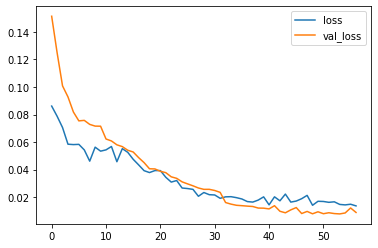

In [13]:
pd.read_csv(model.base_path + '/loss.csv').plot()

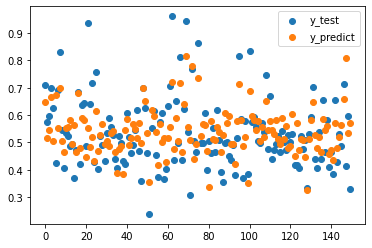

In [14]:
plt.scatter(range(len(model.y_test)), model.y_test, label='y_test')
plt.scatter(range(len(model.y_test)), model.model.predict(model.x_test), label='y_predict')
plt.legend()

In [16]:
model.predict('data/female-face/allpicture/SCUT-FBP-2.jpg')


array([0.29926282], dtype=float32)